# Sep 19th, 2021

**Motivation**: Copy from Sep 18th, but using N = 404 ROIs. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [3]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'graph_type': 'real',
}
mice = Mice(Config(404))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

In [30]:
k = 6
p = 20
svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
group_dir = get_svinet_group_dir(
    results_dir=mice.cfg.results_dir,
    k=k,
    p=p,
    graph_type=svinet_props.get('graph_type', 'real'),
)
print(group_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-404/results/SVINET/gr
oup_results/real-p20-k6

## Load group results

In [31]:
available = [
    e for e in os.listdir(group_dir)
    if '(0.2,1.0;4)' in e
]
file = sorted(available, key=sort_date_latest)[-1]
group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

print(file)

group_bins(0.2,1.0;4)_(2021_09_19).npy

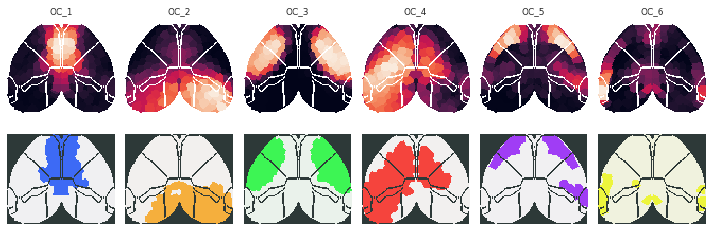

In [34]:
svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
svinet.show(group['pi_avg'], figsize=(10, 3.6))

In [33]:
svinet.path = tmp_dir
svinet.best_qs = [0.65]

In [18]:
svinet.render(group['pi_avg'], cortex_only=True)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/overlap_cortex_k10.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/disjoint_cortex_k10.html

In [19]:
svinet.render(group['pi_avg'], cortex_only=False)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/overlap_brain_k10.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/disjoint_brain_k10.html

In [35]:
svinet.make_clusters(group['pi_avg'])

In [36]:
svinet.clusters

PAL C_6 88% STR C_3 58% C_6 36% CTXsp C_6 100% OLF C_6 83% C_5 5% C_1 1% HIP C_6 99% RHP C_6 92% C_2 8% IB C_6 98% MB C_6 63% C_2 19% HB C_6 81% CB C_2 68% C_6 30% VIS C_2 61% C_4 34% TEa C_6 35% C_5 20% C_2 19% C_4 15% C_3 2% PERI C_6 73% C_5 9% C_2 4% ECT C_6 67% C_5 18% C_2 6% RSP C_2 64% C_1 15% C_4 9% C_6 5% AUD C_4 40% C_2 21% C_5 20% C_6 7% C_3 4% PTLp C_4 51% C_2 45% VISC C_3 74% C_6 12% C_5 6% SS C_3 57% C_4 27% C_2 4% C_1 4% C_5 2% C_6 1% SSp C_3 49% C_4 33% C_1 5% C_2 5% C_5 2% C_6 1% SSp-bfd C_4 46% C_3 22% C_2 18% C_5 9% SSp-ll C_4 57% C_1 34% C_6 5% C_3 2% SSp-m C_3 95% SSp-n C_3 79% C_4 16% SSp-tr C_4 68% C_1 13% C_6 9% C_2 8% SSp-ul C_4 46% C_3 45% C_1 7% SSp-un C_3 47% C_4 44% C_1 4% C_5 1% SSs C_3 78% C_4 11% C_2 2% C_5 2% GU C_3 74% C_5 18% C_6 1% ACA C_1 91% C_4 5% AI C_5 55% C_3 27% C_6 9% MO C_3 43% C_4 28% C_1 19% C_5 7% MOp C_3 58% C_4 26% C_1 11% C_5 1% MOs C_3 30% C_4 29% C_1 26% C_5 12% ILA C_1 96% PL C_1 97% ORB C_1 65% C_5 29% C_3 4% FRP C_1 51% C_5 48%

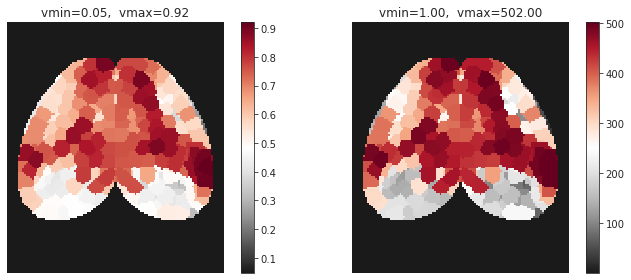

In [37]:
eh = entropy_expect_beta(group['gam_avg'])
ehr = sp_stats.rankdata(eh)

fig, axes = create_figure(1, 2, (10, 4))

for i, ax in enumerate(axes.ravel()):
    data2plt = eh if i == 0 else ehr
    mask = svinet.pi2arr(data2plt.reshape(1, -1), cortex_only=True)[1]
    im = ax.imshow(mask, vmin=min(data2plt), vmax=max(data2plt), cmap='RdGy_r')
    plt.colorbar(im, ax=ax)
    ax.set_title(f"vmin={min(data2plt):0.2f},  vmax={max(data2plt):0.2f}")
remove_ticks(axes)

In [38]:
{k: v.shape for k, v in group.items()}

{
    'cut_oc': (10, 3, 998, 6, 4),
    'cut_nodes': (10, 3, 998, 502, 4),
    'intervals': (4,),
    'gam': (10, 3, 6, 502),
    'gam_avg': (6, 502),
    'gam_all': (10, 3, 998, 6, 502),
    'pi': (10, 3, 6, 502),
    'pi_avg': (6, 502),
    'pi_all': (10, 3, 998, 6, 502),
    'lam': (10, 3, 6, 2),
    'lam_avg': (6, 2),
    'lam_all': (10, 3, 998, 6, 2),
    'beta': (10, 3, 6),
    'beta_avg': (6,)
}

## Continue from here: tomorrow Sept 15th

## Compute $Y_{ij}$

In [39]:
y, y_avg = node_sim_matrix(group)
y.shape, y_avg.shape

((10, 502, 502), (502, 502))

In [40]:
np.isnan(y).sum(), np.isnan(y_avg).sum()

(0, 0)

### Brief t-SNE before moving on

In [41]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(y_avg)
y_emb.shape

(502, 2)

In [42]:
hemis = np.array(['R'] * len(svinet.n2l))
hemis[svinet.l_ids] = 'L'

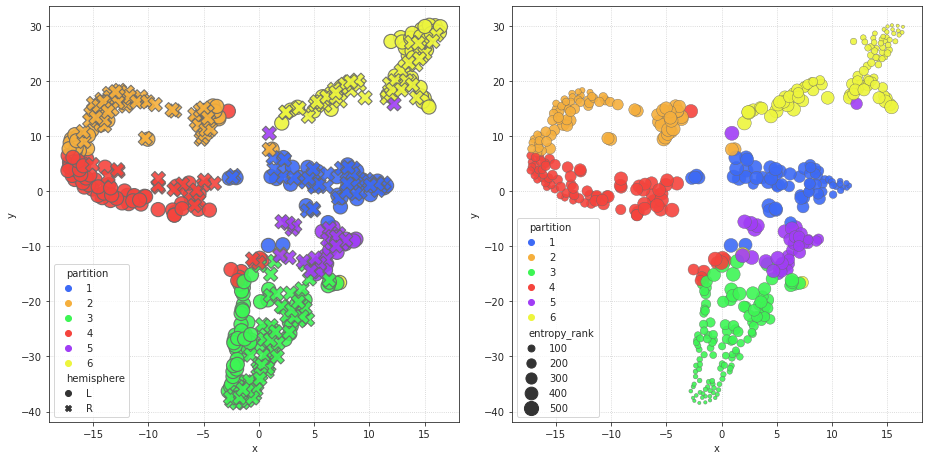

In [43]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(group['pi_avg'], axis=0),
    'hemisphere': hemis,
    'entropy': eh,
    'entropy_rank': ehr,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    markers={'L': 'o', 'R': 'X'},
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy_rank',
    sizes=(10, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

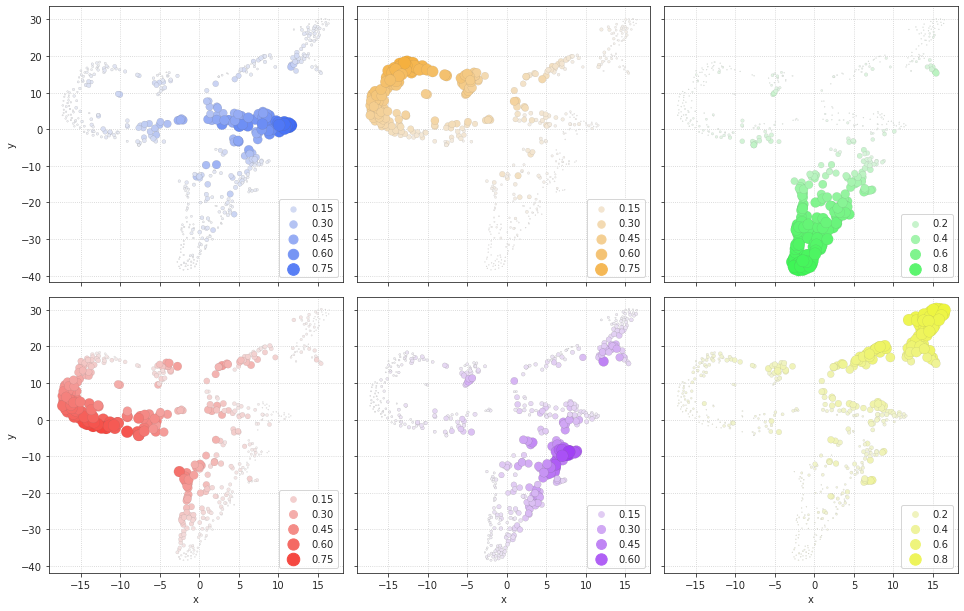

In [44]:
nrows = 2
ncols = int(np.ceil(k / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == k:
        break

    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'strength': group['pi_avg'][i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.legend(loc="lower right")
    ax.grid()
trim_axs(axes, k)
plt.show()

In [45]:
%time pi_vol = svinet.pi2vol(y_avg, cortex_only=True)

CPU times: user 3min, sys: 17.4 s, total: 3min 17s
Wall time: 3min 17s


In [46]:
%time pca_results = node_sim_pca(pi_vol)

CPU times: user 1min 56s, sys: 21.8 s, total: 2min 17s
Wall time: 28.8 s


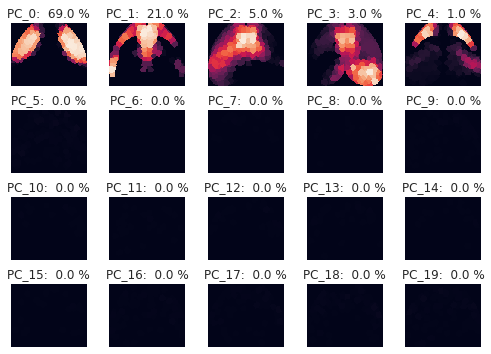

In [47]:
fig, axes = create_figure(4, 5, (7, 5))
for i, ax in enumerate(axes.ravel()):
    arr = pca_results['comps'][i]
    arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
    ax.imshow(arr)
    ax.set_title(f"PC_{i}:  {np.round(100 * pca_results['var_ratio'][i])} %")
remove_ticks(axes)
plt.show()

--------------------------------------------------------------------------------

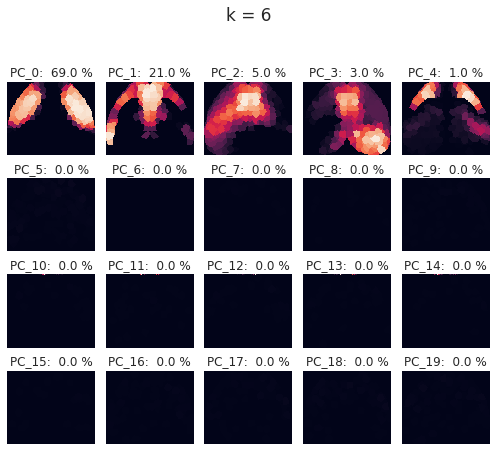

--------------------------------------------------------------------------------

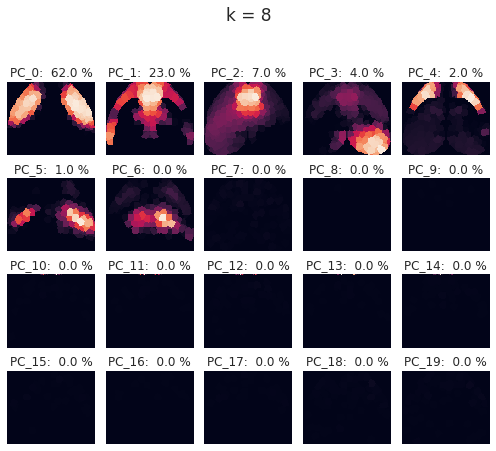

--------------------------------------------------------------------------------

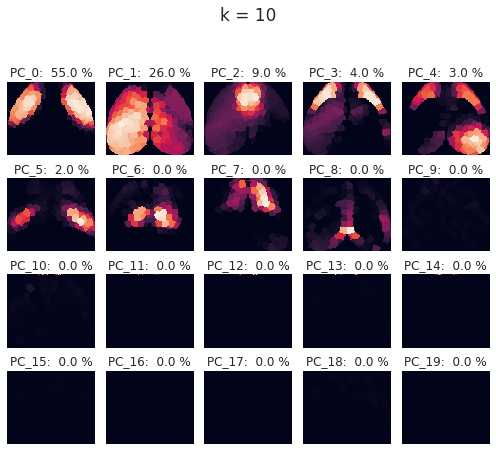

CPU times: user 14min 56s, sys: 54.7 s, total: 15min 51s
Wall time: 10min 17s


In [48]:
%%time

p = 20
y_avg_all = {}
pca_results = {}
for k in range(3, 18):
    svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
    group_dir = get_svinet_group_dir(
        results_dir=mice.cfg.results_dir,
        k=k,
        p=p,
        graph_type='real',
    )
    try:
        available = [
            e for e in os.listdir(group_dir)
            if '(0.2,1.0;4)' in e
        ]
        file = sorted(available, key=sort_date_latest)[-1]
        group = np.load(pjoin(group_dir, file), allow_pickle=True).item()
    except FileNotFoundError:
        continue
    _, y_avg = node_sim_matrix(group)
    y_avg_all[k] = y_avg
    pi_vol = svinet.pi2vol(y_avg, cortex_only=True)
    _results = node_sim_pca(pi_vol)
    pca_results[k] = _results
    
    print('-' * 80)
    fig, axes = create_figure(4, 5, (7, 6))
    for i, ax in enumerate(axes.ravel()):
        arr = _results['comps'][i]
        arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
        ax.imshow(arr)
        ax.set_title(f"PC_{i}:  {np.round(100 * _results['var_ratio'][i])} %")
    fig.suptitle(f"k = {k}", fontsize=17, y=1.05)
    remove_ticks(axes)
    plt.show()
    
    print('\n')

In [49]:
dlist = []
for k, result in pca_results.items():
    cumvar = np.cumsum(result['var_ratio'])
    dlist.append({
        'cumvar': cumvar,
        'k': [k] * len(cumvar),
        'comp': range(1, 1 + len(cumvar)),
    })
df_pca = pd.DataFrame(merge_dicts(dlist))

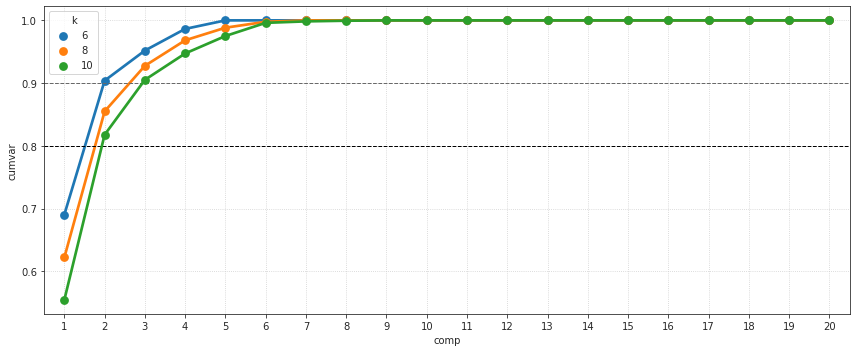

In [50]:
fig, ax = create_figure(1, 1, (12, 5))
sns.pointplot(
    data=df_pca,
    x='comp',
    y='cumvar',
    hue='k',
    ax=ax,
)
ax.axhline(0.8, color='k', ls='--', lw=1)
ax.axhline(0.9, color='dimgrey', ls='--', lw=1)
ax.grid()
plt.show()

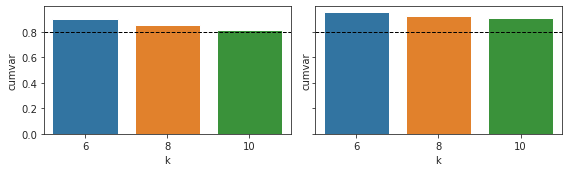

In [51]:
fig, axes = create_figure(1, 2, (8, 2.5), 'ticks', 'all', 'all')
for ncomp, ax in zip([2, 3], axes.ravel()):
    _df = df_pca.loc[df_pca.comp == ncomp]
    sns.barplot(data=_df, x='k', y='cumvar', ax=ax)
    ax.axhline(0.8, color='k', ls='--', lw=1)
    # ax.axhline(0.9, color='dimgrey', ls='--', lw=1)
    # ax.axhspan(0.8, 1.0, color='grey', alpha=0.5, zorder=0)

In [52]:
x_flat = np.concatenate([
    result['x_flat'] for k, result
    in pca_results.items() if k > 5
])
nonzero_ids = np.where(x_flat.sum(0) > 0)[0]
x_flat.shape, len(nonzero_ids)

((1506, 468180), 116936)

In [53]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=20,
    svd_solver='full',
).fit(x_flat[:, nonzero_ids])

comps = np.zeros((len(pca.components_), x_flat.shape[-1]))
comps[:, nonzero_ids] = pca.components_
comps = comps.reshape((-1, *result['shape'][1:]))

np.round(pca.explained_variance_ratio_ * 100)

array([62., 23.,  7.,  4.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

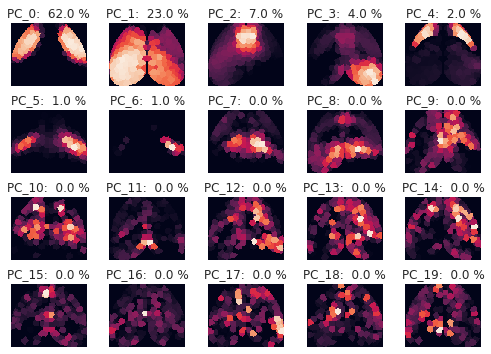

In [54]:
fig, axes = create_figure(4, 5, (7, 5))
for i, ax in enumerate(axes.ravel()):
    arr = comps[i]
    arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
    ax.imshow(arr)
    ax.set_title(f"PC_{i}:  {np.round(100 * pca.explained_variance_ratio_[i])} %")
remove_ticks(axes)
plt.show()

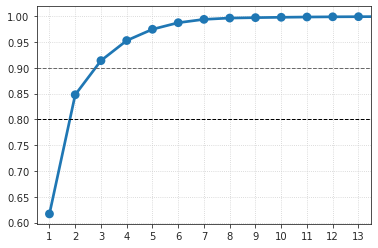

In [55]:
s = pd.Series(data=np.cumsum(pca.explained_variance_ratio_), index=range(1, 21))
sns.pointplot(x=s.index, y=s.values)
plt.axhline(0.8, color='k', ls='--', lw=1)
plt.axhline(0.9, color='dimgrey', ls='--', lw=1)
plt.xlim(-0.5, 12.5)
plt.grid()

In [56]:
_y_avg = np.concatenate([
    np.expand_dims(v, 0) for k, v in
    y_avg_all.items() if k > 3
])
_y_avg.shape

(3, 502, 502)

In [72]:
n_clusters = 5
svinet = SVINET(mice, n_clusters, p, 'sub-SLC', verbose=False)

comps, model = fit_kmeans(
    data=_y_avg.mean(0),# _y_avg.reshape(-1, _y_avg.shape[-1]),
    n_clusters=n_clusters,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
comps /= comps.sum(0, keepdims=True)
gmap = svinet.align_centroid_to_structs(comps)
comps = comps[gmap]
comps.shape

(5, 502)

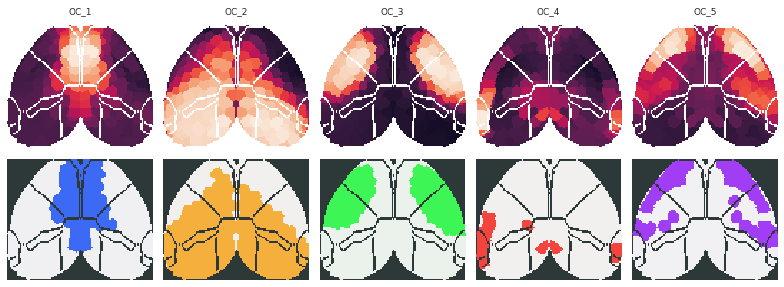

In [73]:
svinet.show(comps, figsize=(11, 4.2))

In [28]:
svinet.best_qs = [0.75]
svinet.path = tmp_dir
svinet.render(comps)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/overlap_cortex_k5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/disjoint_cortex_k5.html

In [36]:
svinet.render(comps, False)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/overlap_brain_k5.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/disjoint_brain_k5.html

<matplotlib.colorbar.Colorbar object at 0x7f8d28efe250>

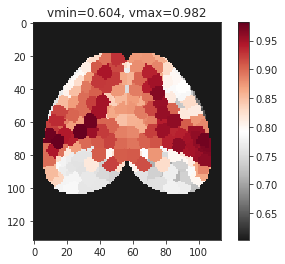

In [74]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h), cmap='RdGy_r')
plt.title(f"vmin={min(h):.3f}, vmax={max(h):.3f}")
plt.colorbar()

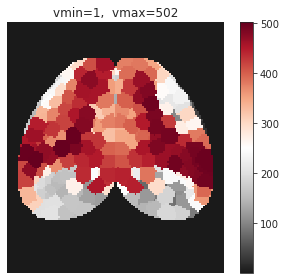

In [75]:
fig, ax = create_figure(1, 1, (5, 4))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
hr = sp_stats.rankdata(h)
mask = svinet.pi2arr(hr.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(hr), vmax=max(hr), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(hr):0.0f},  vmax={max(hr):0.0f}")
remove_ticks(ax)

<AxesSubplot:ylabel='Count'>

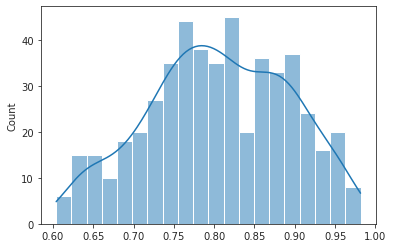

In [76]:
sns.histplot(h, bins=20, kde=True)

In [77]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(_y_avg.mean(0))

y_emb.shape

(502, 2)

In [78]:
hemis = np.array(['R'] * len(svinet.n2l))
hemis[svinet.l_ids] = 'L'

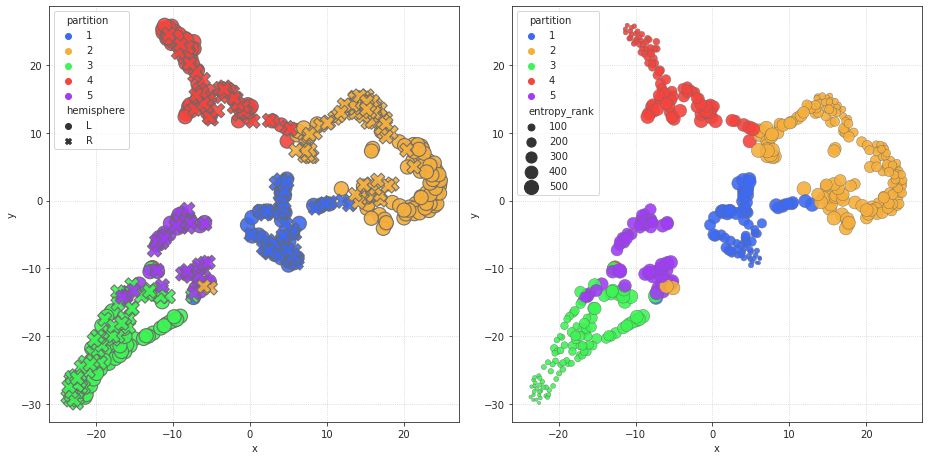

In [79]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
    'entropy_rank': hr,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    markers={'L': 'o', 'R': 'X'},
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy_rank',
    sizes=(10, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

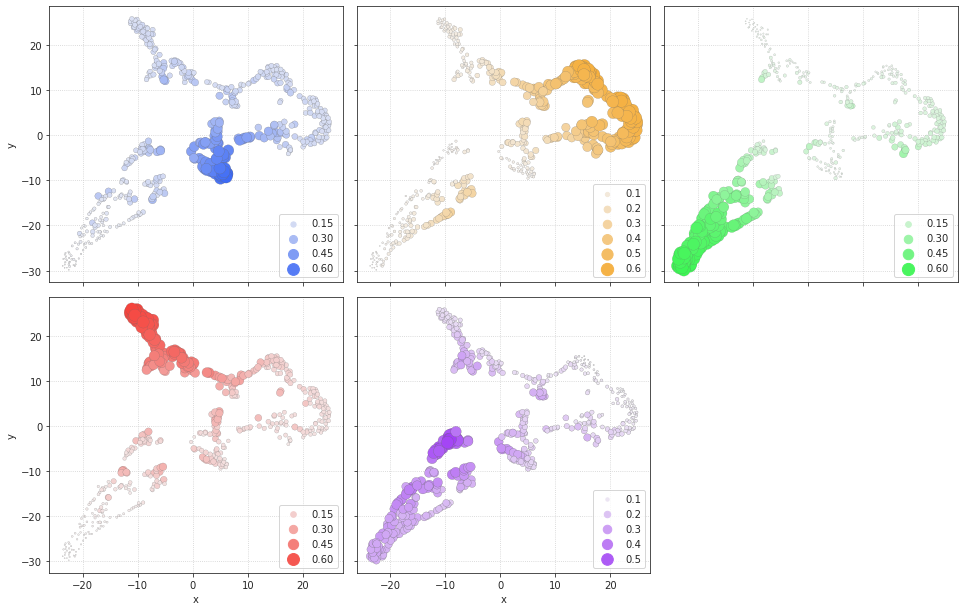

In [80]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'strength': comps[i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.legend(loc="lower right")
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()